## Sagnac Frequency - Backscatter Correction - RV Backscatter

Explore the longterm behaviour of the RV sagnac beat

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.rotate_romy_ZUV_ZNE import __rotate_romy_ZUV_ZNE
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [3]:
config = {}

config['ring'] = "V"

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"


config['tbeg'] = UTCDateTime("2024-05-22 16:00")
# config['tend'] = UTCDateTime("2024-06-27 00:00")
config['tend'] = UTCDateTime().now()

# config['tbeg'] = UTCDateTime("2024-05-31 00:00")
# config['tend'] = UTCDateTime("2024-06-01 00:00")

flim1, flim2 = 447.726, 447.745



## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_out_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"


config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

### Load backscatter data

In [4]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

### Compute Backscatter (again)

In [5]:
from functions.backscatter_correction import __backscatter_correction

In [6]:
# unwrap phases as one time series
# bs['fj_ph'] = np.unwrap(bs.fj_ph)
# bs['f1_ph'] = np.unwrap(bs.f1_ph)
# bs['f2_ph'] = np.unwrap(bs.f2_ph)

# use complete unwrapped phases
bs['fj_ph'] = np.unwrap(bs.fj_phw)
bs['f1_ph'] = np.unwrap(bs.f1_phw)
bs['f2_ph'] = np.unwrap(bs.f2_phw)

# fractional beat modulations
m01 = bs.f1_ac / bs.f1_dc
m02 = bs.f2_ac / bs.f2_dc

# phase difference
ph1 = bs.f1_ph
ph2 = bs.f2_ph
phase0 = ph2 - ph1

# beat signal observed
w_obs = bs.fj_fs

# compute backscatter corrected signal
bs['fj_bs'] = __backscatter_correction(m01, m02, phase0, w_obs, np.median(bs.fj_fs), cm_filter_factor=1.033)


In [7]:
# plt.plot(__smooth(bs.f2_ac/bs.f2_dc/4, 180))
# plt.plot(__smooth(bs.f1_ac/bs.f1_dc/4, 180))

# plt.ylim(flim1, flim2)

In [8]:
# plt.figure(figsize=(15, 5))
# plt.plot(bs.time_sec[0:180]/86400, bs.fj_fs[0:180])
# plt.plot(bs.time_sec[0:180]/86400, bs.fj_bs[0:180])

# # plt.plot(bs.time_sec/86400, gaussian_filter1d(bs.fj_bs, 2))

# plt.ylim(flim1, flim2)

### Find phase jumps

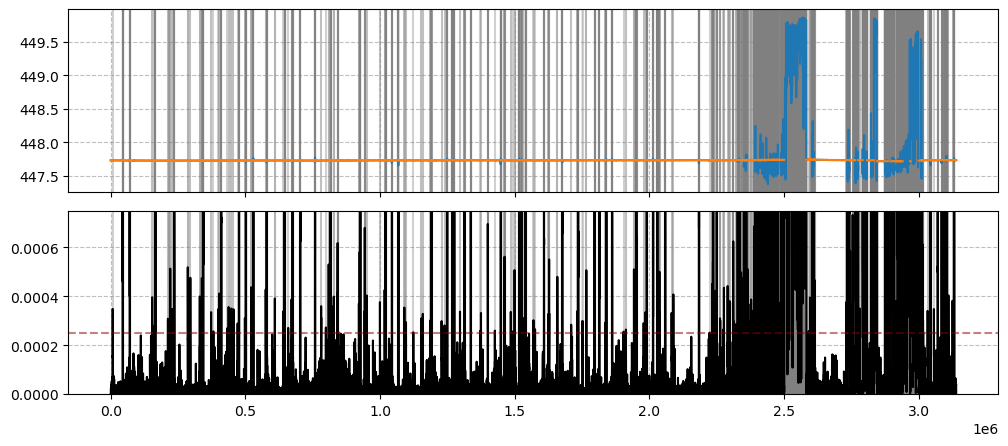

In [9]:
def get_phase_jumps(arr, times, LT, ST, amp_threshold, plot=True):

    import numpy as np
    from scipy.signal import hilbert
    from functions.smoothing import __smooth

    def sta_lta_detect(_data, threshold_upper, threshold_lower=None):

        N = len(_data)

        detection = np.ones(N)
        ratio = np.zeros(N)

        triggered = False
        for n in range(N):

            if n < LT:
                continue

            # compupte LTA, STA and ratio
            LTA = np.nanmean(abs(_data[n-int(LT):n]))
            STA = np.nanmean(abs(_data[n-int(ST):n]))
            ratio[n] = abs(STA-LTA)

            if triggered and ratio[n] > threshold_lower and threshold_lower is not None:
                detection[n] = 0
                continue
            else:
                triggered = False

            if ratio[n] > threshold_upper and threshold_lower is not None:
                detection[n] = np.nan
                detection[n-1] = np.nan
                triggered = True

        # detect events based on threshold
        for n, a in enumerate(ratio):
            if a > threshold_upper:
                detection[n] = np.nan
                detection[n-1] = np.nan

        return detection, ratio


    amp_threshold_lower = 0.5

    # dpha = __smooth(dpha, 10)

    # 1st derivative of amplitude
    damp = np.gradient(arr)

    # 2nd derivative
    # damp = np.gradient(damp)

    # absolute values
    damp = abs(damp)

    detect, amp_ratio = sta_lta_detect(damp, amp_threshold)

    if plot:

        import matplotlib.pyplot as plt

        Nrow, Ncol = 2, 1

        font = 12

        fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

        plt.subplots_adjust(hspace=0.1)

        ax[0].plot(times, arr)
        ax[0].plot(times, arr*np.array(detect))

        ax[1].plot(times, amp_ratio, "k")
        ax[1].axhline(amp_threshold, color="darkred", alpha=0.5, ls="--")
        ax[1].set_ylim(0, 3*amp_threshold)

        for _k in range(Nrow):
            ax[_k].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

        for _n, d in enumerate(detect):
            if np.isnan(d):
                ax[0].axvline(times[_n], 0, np.nanmax(arr)*2, color="grey", alpha=0.2, zorder=1)
                ax[1].axvline(times[_n], 0, 10, color="grey", alpha=0.2, zorder=1)

        plt.show();

    # change detections to one and everything else to zero
    detect2 = abs(np.nan_to_num(detect, 0) - 1)

    return np.array(amp_ratio), np.array(detect2)


x1 = 1000
x2 = x1+6000

# data0 = np.array(bs.fj_fs[x1:x2])
# time0 = np.array(bs.time_sec[x1:x2])

data0 = np.array(bs.fj_fs)
time0 = np.array(bs.time_sec)

ratio, detect = get_phase_jumps(data0, time0, 10, 3, amp_threshold=0.00025)


52320 52320


(0.5, 9112.266701898447)

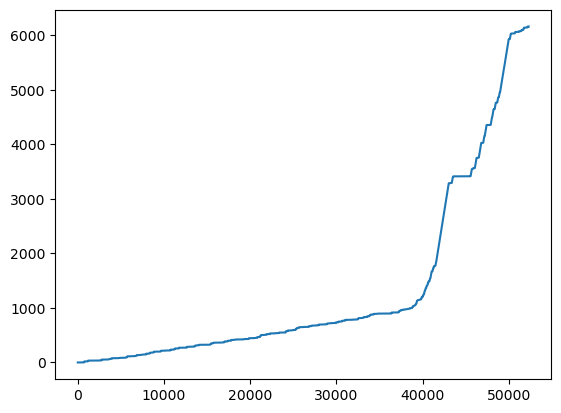

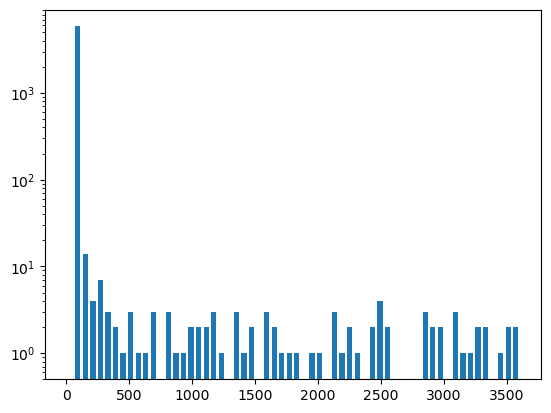

In [10]:
print(len(bs.fj_fs), len(detect))


mask = np.where(detect==1, 1, 0)

time_mask = time0 * detect

time_inter = time_mask[time_mask != 0]

inter = np.diff(time_inter)
inter[0] = inter[1]

plt.figure()
plt.plot(np.cumsum(detect))

NN = 3600
plt.figure()
plt.hist(inter, bins=int(NN/60), range=(0, NN), log=True, rwidth=0.7)
plt.ylim(bottom=0.5)

In [11]:
# data = np.array(bs.fj_fs)

# for _i in range(len(data)):

#     if detect[_i] == 1:
#         left = np.nanmean(data[_i-8:_i-3])
#         right = np.nanmean(data[_i+3:_i+8])

#         diff = left - right

#         data[_i-3:_i] = left

#         data[_i:] += diff


# # plt.plot(bs.fj_fs[:-40000])
# # plt.plot(data[:-40000])

# plt.plot(bs.fj_fs)
# plt.plot(data)

# # plt.ylim(flim1, flim2)

### Cut corrupt data periods

In [12]:
bs['fj_fs'] = np.where((bs.fj_fs > flim2), np.nan, bs.fj_fs)
bs['fj_fs'] = np.where((bs.fj_fs < flim1), np.nan, bs.fj_fs)

bs['fj_bs'] = np.where((bs.fj_bs > flim2), np.nan, bs.fj_bs)
bs['fj_bs'] = np.where((bs.fj_bs < flim1), np.nan, bs.fj_bs)

In [13]:
# times = [("2023-12-04T09:11", "2023-12-04T18:01")]

# for t1, t2 in times:
#     bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
#     bs['fj_bs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_bs)


# bs['fj_fs'] = np.nan_to_num(bs['fj_fs'], nan=np.nanmedian(bs['fj_fs']))
# bs['fj_bs'] = np.nan_to_num(bs['fj_bs'], nan=np.nanmedian(bs['fj_bs']))

In [14]:
from functions.load_mlti import __load_mlti

mlti = __load_mlti(config['tbeg'], config['tend'], config['ring'], archive_path)

In [15]:
from functions.get_mlti_intervals import __get_mlti_intervals

mlti_t1, mlti_t2 = __get_mlti_intervals(mlti.time_utc)

In [16]:
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mlti_t1, mlti_t2, t_offset_sec=180)
bs = __mlti_intervals_to_NaN(bs, "fj_bs", "time1", mlti_t1, mlti_t2, t_offset_sec=180)

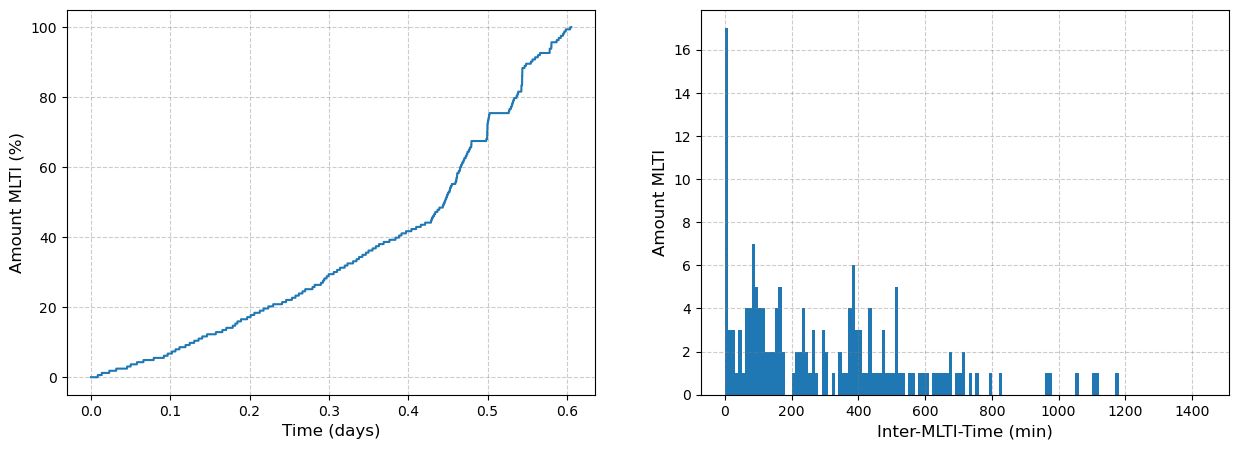

In [17]:
from functions.get_mlti_statistics import __get_mlti_statistics

arr_mlti, mlti_cumsum, mlti_cumsum_perc, mlti_inter_sec = __get_mlti_statistics(mlti_t1, bs.time1, plot=True, ylog=False)

### Apply special filter sections

In [18]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

In [19]:
from functions.smoothing import __smooth

n_minutes = 60

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, n_minutes)

### Load LXX maintenance

In [20]:
from functions.load_lxx import __load_lxx

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

In [21]:
from functions.get_lxx_intervals import __get_lxx_intervals

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

In [22]:
bs

,index,time1,time2,fj_fs,fj_ac,fj_dc,fj_ph,fj_st,fj_phw,f1_fs,...,bscorrection,term,time_sec,fj_bs,fj_fs_nan,fj_bs_nan,fj_fs_inter,fj_bs_inter,fj_fs_smooth,fj_bs_smooth
0,0,2024-05-22T16:00:00.000000Z,2024-05-22T16:01:00.000000Z,447.732009,0.437290,0.413326,0.674936,0.002880,0.674936,447.733934,...,0.000889,0.999998,60.0,447.731119,447.732009,447.731119,447.732009,447.731119,NaN,NaN
1,1,2024-05-22T16:01:00.000000Z,2024-05-22T16:02:00.000000Z,447.732206,0.435066,0.413298,0.327300,0.003307,0.327300,447.731479,...,0.000872,0.999998,120.0,447.731334,447.732206,447.731334,447.732206,447.731334,NaN,NaN
2,2,2024-05-22T16:02:00.000000Z,2024-05-22T16:03:00.000000Z,447.732219,0.435419,0.413314,-0.128219,0.002920,-0.128219,447.732569,...,0.000858,0.999998,180.0,447.731360,447.732219,447.731360,447.732219,447.731360,NaN,NaN
3,3,2024-05-22T16:03:00.000000Z,2024-05-22T16:04:00.000000Z,447.732048,0.435024,0.413312,-0.580535,0.002817,-0.580535,447.732180,...,0.000855,0.999998,240.0,447.731193,447.732048,447.731193,447.732048,447.731193,NaN,NaN
4,4,2024-05-22T16:04:00.000000Z,2024-05-22T16:05:00.000000Z,447.732043,0.434762,0.413296,-1.042712,0.003099,-1.042712,447.732200,...,0.000851,0.999998,300.0,447.731191,447.732043,447.731191,447.732043,447.731191,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52315,55,2024-06-27T23:55:00.000000Z,2024-06-27T23:56:00.000000Z,447.735394,0.299637,0.362808,-13519.763878,0.001414,1.650903,447.735760,...,0.000154,1.000000,3138960.0,447.735240,447.735394,447.735240,447.735394,447.735240,NaN,NaN
52316,56,2024-06-27T23:56:00.000000Z,2024-06-27T23:57:00.000000Z,447.735347,0.299533,0.362801,-13518.980143,0.001547,2.434638,447.735581,...,0.000158,1.000000,3139020.0,447.735189,447.735347,447.735189,447.735347,447.735189,NaN,NaN
52317,57,2024-06-27T23:57:00.000000Z,2024-06-27T23:58:00.000000Z,447.735429,0.297116,0.362830,-13518.188669,0.001931,-3.057074,447.736356,...,0.000162,1.000000,3139080.0,447.735267,447.735429,447.735267,447.735429,447.735267,NaN,NaN
52318,58,2024-06-27T23:58:00.000000Z,2024-06-27T23:59:00.000000Z,447.735525,0.294691,0.362844,-13517.540241,0.001593,-2.408645,447.735244,...,0.000104,1.000000,3139140.0,447.735421,447.735525,447.735421,447.735525,447.735421,NaN,NaN


### Checkup Plot

/tmp/ipykernel_453531/1830721788.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


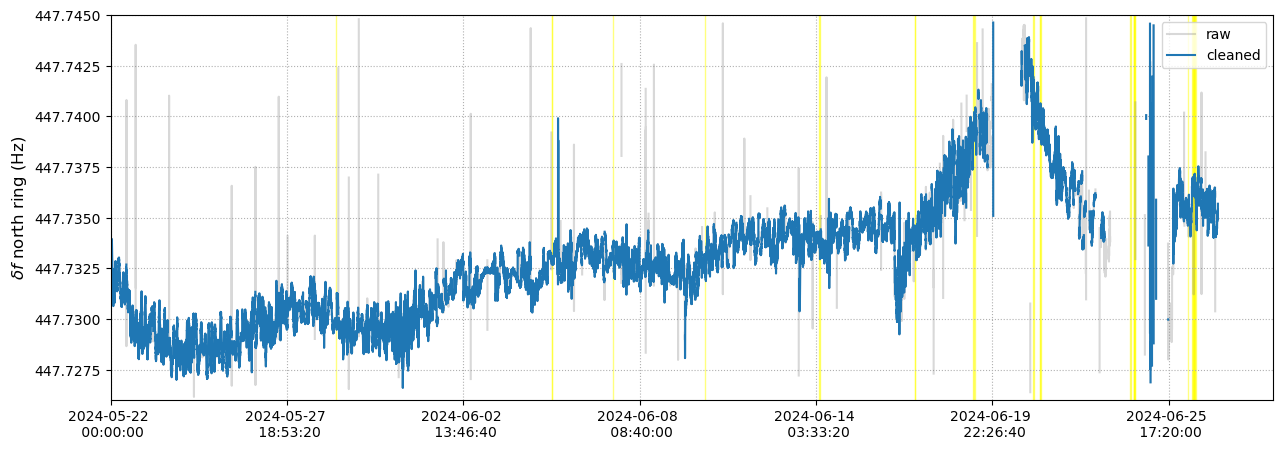

In [23]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1
    ref_date = str(bs.time1.iloc[0])[:10]

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    ax.set_xlim(left=0)

    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    ## add dates to x-axis
    tcks = ax.get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax.set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring'}_cleaned.png", format="png", dpi=150, bbox_inches='tight')


In [24]:
from functions.multitaper_psd import __multitaper_psd
from scipy.signal import detrend

bs['fj_bs_smooth_inter'] = __interpolate_nan(np.array(bs.fj_bs_smooth))

dat1 = detrend(bs.fj_fs_inter, type="linear")
dat2 = detrend(bs.fj_bs_inter, type="linear")
dat3 = detrend(bs.fj_bs_smooth_inter, type="linear")

# f1, psd1 = __multitaper_psd(dat1, 60, n_win=10, time_bandwidth=3.5)
# f2, psd2 = __multitaper_psd(dat2, 60, n_win=10, time_bandwidth=3.5)

# f1, psd1 = __welch_psd(dat1, 60, twin_sec=86400)
# f2, psd2 = __welch_psd(dat2, 60, twin_sec=86400)

psd1, f1, pha1 = __get_fft(dat1, 60, window="cosine")
psd2, f2, pha2 = __get_fft(dat2, 60, window="cosine")
psd3, f3, pha3 = __get_fft(dat3, 60, window="cosine")
# psd1, f1, pha1 = __get_fft(dat1, 60)
# psd2, f2, pha2 = __get_fft(dat2, 60)
# psd3, f3, pha3 = __get_fft(dat3, 60)

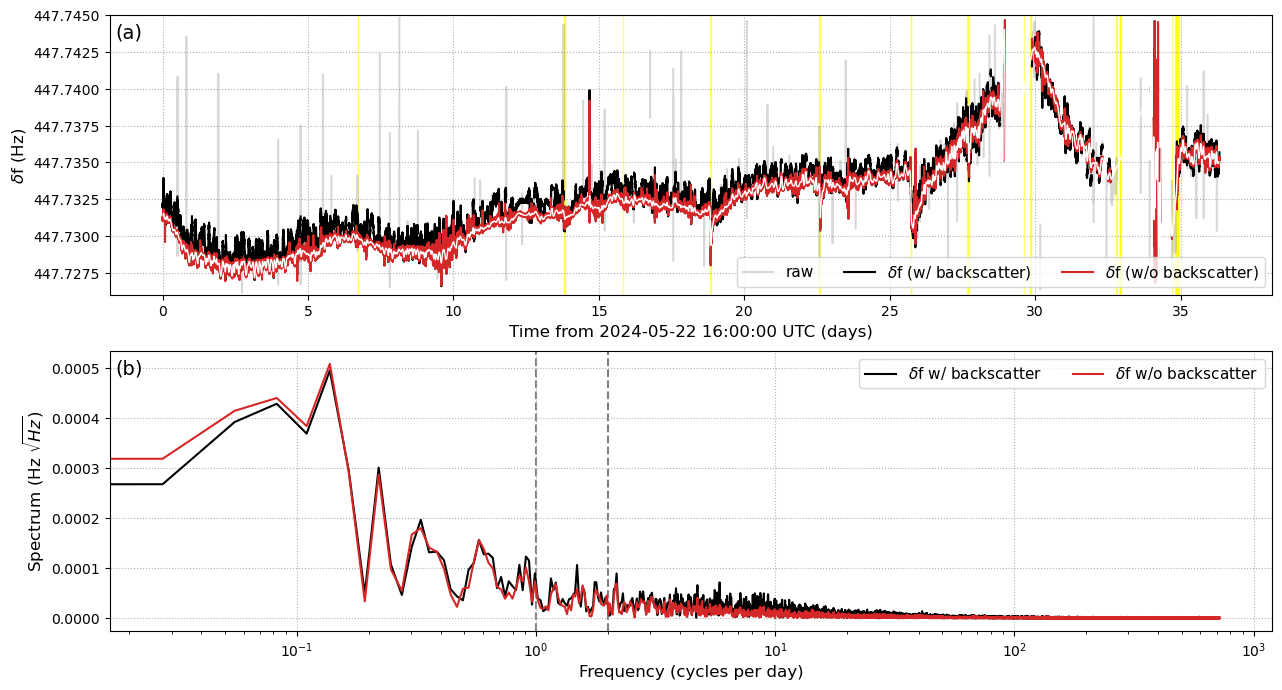

In [25]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    tscale, tunit = 1/86400, "days"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax[0].plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax[0].plot(bs.time_sec*tscale, bs.fj_bs_smooth, color="w", lw=1)

    ax[0].ticklabel_format(useOffset=False)

    ax[1].semilogx(f1*86400, psd1, color="black", label=f"$\delta$f w/ backscatter")
    ax[1].semilogx(f2*86400, psd2, color="tab:red", label=f"$\delta$f w/o backscatter")
    # ax[1].semilogx(f3, psd3, color="tab:grey", label=f"$\delta$f w/o backscatter (smooth)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)

    ax[0].legend(loc=4, fontsize=font-1, ncol=3)
    ax[1].legend(loc=1, fontsize=font-1, ncol=3)

    ax[0].set_ylim(flim1, flim2)


    ax[0].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax[0].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC ({tunit})", fontsize=font)

    # ax[1].set_ylabel("PSD (Hz$^2$ /Hz)", fontsize=font)
    ax[1].set_ylabel("Spectrum (Hz $\sqrt{Hz}$)", fontsize=font)
    ax[1].set_xlabel("Frequency (cycles per day)", fontsize=font)

    ax[1].axvline(1/(12*3600)*86400, ls="--", color="grey", zorder=0)
    ax[1].axvline(1/(24*3600)*86400, ls="--", color="grey", zorder=0)

    ax[0].text(.005, .97, "(a)", ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.005, .97, "(b)", ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax[0].fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_backscatter_spectrum_{config['tbeg']}_{config['tend']}.png", format="png", dpi=150, bbox_inches='tight')


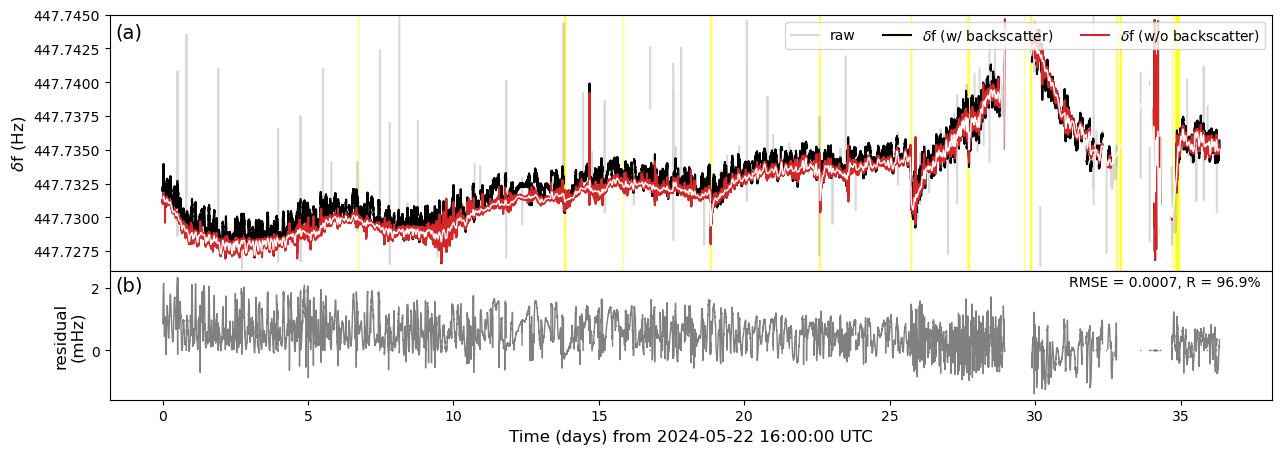

In [26]:
def __makeplot_residual():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd
    from functions.to_dB import __to_dB
    from functions.variance_reduction import __variance_reduction


    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __variance_reduction(arr1, arr2):
        from numpy import var
        return round(( var(arr1) - var(arr2) ) / var(arr1) * 100, 2)

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)



    tscale, tunit = 1/86400, "days"


    Ncol, Nrow = 1, 3

    font = 12

    lw = 1

    scale, unit = 1, f"Hz"

    fig = plt.figure(figsize=(15, 5))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])

    ax1.plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax1.plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_smooth, color="w", lw=1)

    ax2.plot(bs.time_sec*tscale, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", lw=lw)
    # ax2.fill_between(bs.time_sec*tscale, 0, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", alpha=0.3)

    ax1.set_ylim(flim1, flim2)
    ax1.ticklabel_format(useOffset=False)
    ax1.legend(loc=1, ncol=3)

    ax1.set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax2.set_ylabel(f"residual\n(mHz)", fontsize=font)

    for ax in [ax1]:
        ax.get_xaxis().set_visible(False)

    ax2.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)

    R = __variance_reduction(bs.fj_fs, bs.fj_fs - bs.fj_bs)

    txt = f"RMSE = {__rmse(bs.fj_fs, bs.fj_bs)}, R = {R}%"
    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    # ax1.set_title(f"{til_in[0].stats.station} & {acc_in[0].stats.station} | f = {fmin} - {fmax} Hz")

    # ax1.grid(ls=":", zorder=0)
    # ax2.grid(ls=":", zorder=0)

    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax1.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.plot();
    return fig

fig = __makeplot_residual()

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_backscatter_residual_{config['tbeg']}_{config['tend']}.png", format="png", dpi=150, bbox_inches='tight')


In [27]:
# from andbro__store_as_pickle import __store_as_pickle

# __store_as_pickle(fig, "/home/andbro/notebooks/RomyMonitor/images/fig0.pkl")

## Plot with zoom-in

In [28]:
# %matplotlib tk

17280 19872


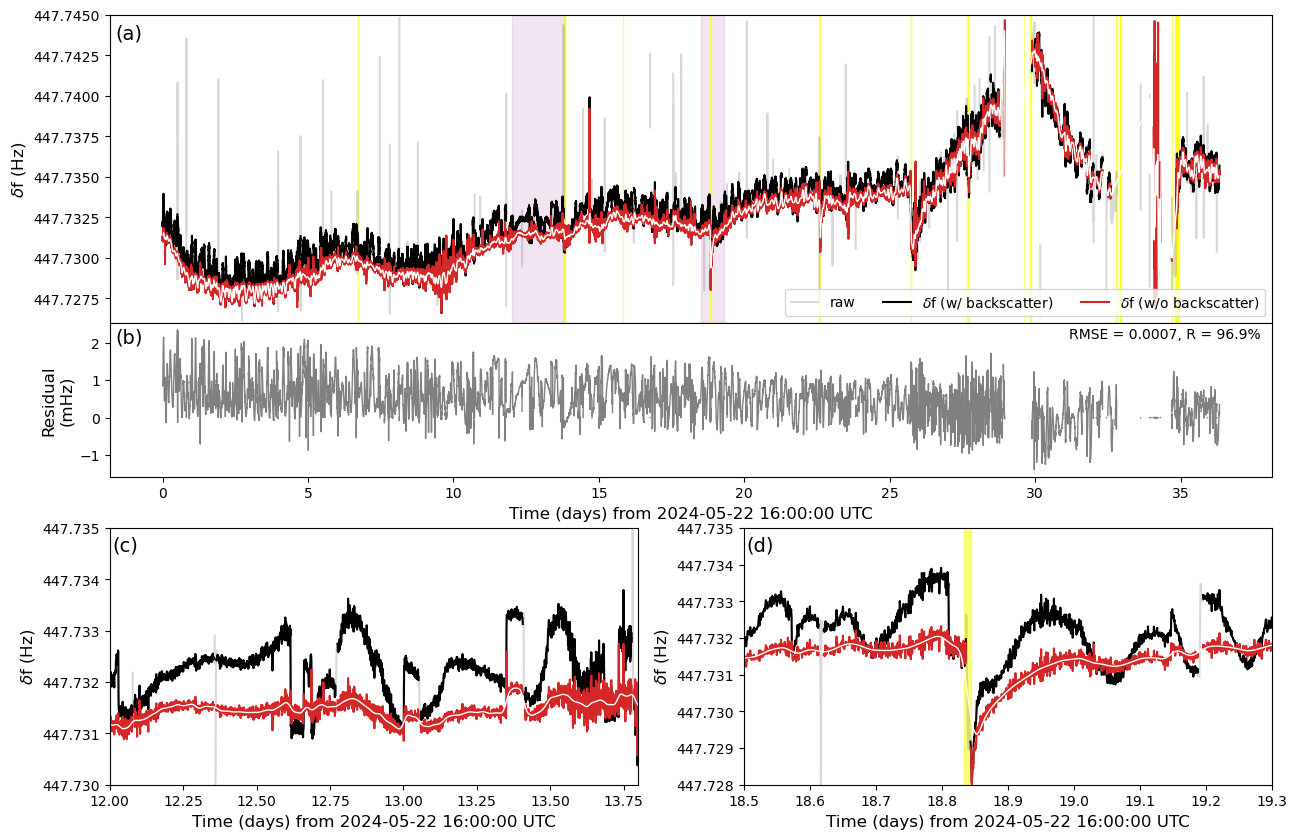

In [29]:
def __makeplot_residual():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd
    from functions.to_dB import __to_dB
    from functions.variance_reduction import __variance_reduction


    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __variance_reduction(arr1, arr2):
        from numpy import var
        return round(( var(arr1) - var(arr2) ) / var(arr1) * 100, 2)

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)



    tscale, tunit = 1/86400, "days"


    Ncol, Nrow = 2, 5

    font = 12

    lw = 1

    scale, unit = 1, f"Hz"

    fig = plt.figure(figsize=(15, 10))

    gs1 = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs2 = GridSpec(Nrow, Ncol, figure=fig, hspace=1)

    ax1 = fig.add_subplot(gs1[0:2, :])
    ax2 = fig.add_subplot(gs1[2, :])
    ax3 = fig.add_subplot(gs2[3:5, :1])
    ax4 = fig.add_subplot(gs2[3:5, 1:])

    ax1.plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax1.plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_smooth, color="w", lw=1)

    ax2.plot(bs.time_sec*tscale, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", lw=lw)
    # ax2.fill_between(bs.time_sec*tscale, 0, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", alpha=0.3)

    t31, t32 = 2.0, 2.7 # days
    t31, t32 = 12.0, 13.8 # days
    # t31, t32 = 8.0, 9.0 # days
    n31, n32 = int(t31*1440), int(t32*1440)
    print(n31, n32)
    ax3.plot(bs.time_sec[n31:n32]*tscale, bs.fj_fs[n31:n32], color="tab:grey", alpha=0.3, label="raw")
    ax3.plot(bs.time_sec[n31:n32]*tscale, bs.fj_fs_nan[n31:n32], color="black", label=f"$\delta$f (w/ backscatter)")
    ax3.plot(bs.time_sec[n31:n32]*tscale, bs.fj_bs_nan[n31:n32], color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax3.plot(bs.time_sec[n31:n32]*tscale, bs.fj_bs_smooth[n31:n32], color="w", lw=1)
    ax3.set_xlim(t31, t32)

    t41 ,t42 = 18.5, 19.3 # days
    n41, n42 = int(t41*1440), int(t42*1440)
    ax4.plot(bs.time_sec[n41:n42]*tscale, bs.fj_fs[n41:n42], color="tab:grey", alpha=0.3, label="raw")
    ax4.plot(bs.time_sec[n41:n42]*tscale, bs.fj_fs_nan[n41:n42], color="black", label=f"$\delta$f (w/ backscatter)")
    ax4.plot(bs.time_sec[n41:n42]*tscale, bs.fj_bs_nan[n41:n42], color="tab:red", label=f"$\delta$f (w/o backscatter)")
    ax4.plot(bs.time_sec[n41:n42]*tscale, bs.fj_bs_smooth[n41:n42], color="w", lw=1)
    ax4.set_xlim(t41, t42)


    ax1.fill_betweenx([flim1, flim2],
                      bs.time_sec[n31]*tscale, bs.time_sec[n32]*tscale,
                      color="purple", alpha=0.1
                     )
    ax1.fill_betweenx([flim1, flim2],
                      bs.time_sec[n41]*tscale, bs.time_sec[n42]*tscale,
                      color="purple", alpha=0.1
                     )

    ax1.set_ylim(flim1, flim2)
    ax3.set_ylim(447.730, 447.735)
    ax4.set_ylim(447.728, 447.735)

    for ax in [ax1, ax3, ax4]:
        ax.ticklabel_format(useOffset=False)
        ax.set_ylabel(f"$\delta$f (Hz)", fontsize=font)

    ax1.legend(loc=4, ncol=3)

    ax2.set_ylabel(f"Residual\n(mHz)", fontsize=font)

    for ax in [ax1]:
        ax.get_xaxis().set_visible(False)

    ax2.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)
    ax3.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)
    ax4.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)

    R = __variance_reduction(bs.fj_fs, bs.fj_fs - bs.fj_bs)

    txt = f"RMSE = {__rmse(bs.fj_fs, bs.fj_bs)}, R = {R}%"
    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    # ax1.set_title(f"{til_in[0].stats.station} & {acc_in[0].stats.station} | f = {fmin} - {fmax} Hz")


    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax1.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)
        ax3.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)
        ax4.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.plot();
    return fig

fig = __makeplot_residual()

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_backscatter_residual_{config['tbeg']}_{config['tend']}_zoomin.png",
            format="png", dpi=150, bbox_inches='tight')


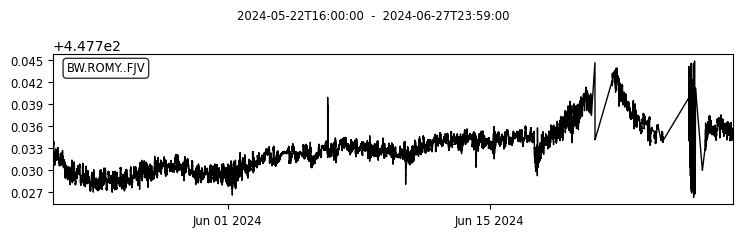

In [30]:
from functions.sagnac_to_tilt import __sagnac_to_tilt

dff = np.array(bs.fj_fs_inter)

rx = Trace()
rx.data = dff
rx.stats.delta = 60
rx.stats.starttime = bs.time1.iloc[0]
rx.stats.station = "ROMY"
rx.stats.channel = f"FJ{config['ring']}"
rx.stats.network = "BW"

rx = Stream(rx)

rx.plot();

In [37]:
t1, t2 = config['tbeg']+12.0298*86400, config['tbeg']+12.613*86400

In [38]:
_ps1 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.01.LKI", t1-3600, t2+3600)
_ps7 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.07.LKI", t1-3600, t2+3600)
_ps9 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.09.LKI", t1-3600, t2+3600)

In [39]:
for _ps in [_ps1, _ps7, _ps9]:
    _ps.detrend("demean")
    _ps.decimate(10, no_filter=False)
    _ps.decimate(6, no_filter=False)



In [40]:
def __get_diff(arr):
    return round(arr[~np.isnan(arr)][-1] - arr[~np.isnan(arr)][0], 5)

In [41]:
# selected interval and surrounding
_rx0 = rx.copy()
rx0 = _rx0.trim(t1-3600, t2+3600)[0].data
trx0 = _rx0[0].times(reftime=t1)

_ps01 = _ps1.copy()
ps01 = _ps01[0].data
tps01 = _ps01[0].times(reftime=t1)

_ps07 = _ps7.copy()
ps07 = _ps07[0].data
tps07 = _ps07[0].times(reftime=t1)

_ps09 = _ps9.copy()
ps09 = _ps09[0].data
tps09 = _ps09[0].times(reftime=t1)

# selected interval
_rx1 = rx.copy()
rx1 = _rx1.trim(t1, t2)[0].data
trx1 = _rx1[0].times(reftime=t1)


_ps11 = _ps1.copy()
ps11 = _ps11.trim(t1, t2)[0].data
tps11 = _ps11[0].times(reftime=t1)

_ps17 = _ps7.copy()
ps17 = _ps17.trim(t1, t2)[0].data
tps17 = _ps17[0].times(reftime=t1)

_ps19 = _ps9.copy()
ps19 = _ps19.trim(t1, t2)[0].data
tps19 = _ps19[0].times(reftime=t1)

rn = 100
_reduce = np.nanmean(ps11[:rn])
ps11 -= _reduce
ps01 -= _reduce
_reduce = np.nanmean(ps17[:rn])
ps17 -= _reduce
ps07 -= _reduce
_reduce = np.nanmean(ps19[:rn])
ps19 -= _reduce
ps09 -= _reduce

rn = 10
_reduce = np.nanmean(rx1[:rn])
rx1 -= _reduce
rx0 -= _reduce

ps11_smooth = __smooth(ps01, 120)
ps17_smooth = __smooth(ps07, 120)
ps19_smooth = __smooth(ps09, 120)

rx1_smooth = __smooth(rx1, 180)
rx11_smooth = __smooth(rx0, 180)


print("ps11: ", __get_diff(ps11_smooth))
print("ps17: ", __get_diff(ps17_smooth))
print("ps19: ", __get_diff(ps19_smooth))

ps11:  -0.00126
ps17:  0.03788
ps19:  0.01375


In [42]:
_ps_diff = np.nanmean(ps11[-10:]) - np.nanmean(ps1[:10])
print(_ps_diff)

_rx_diff = np.nanmean(rx1[-10:]) - np.nanmean(rx1[:10])
print(_rx_diff)

NameError: name 'ps1' is not defined

In [43]:
alpha = 15e-6 # m/m/°C

strain = 633e-9 / 36

strain / alpha

0.0011722222222222223

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


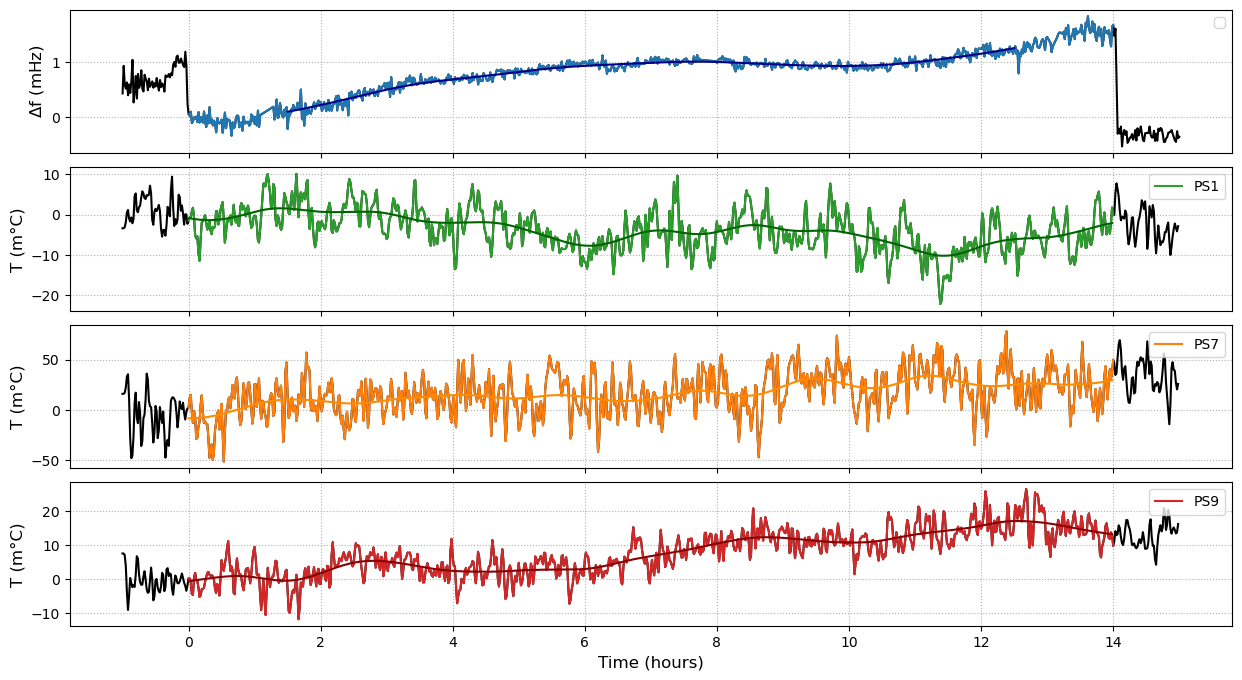

In [44]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    tscale, tunit = 1/3600, "hours"
    Tscale, Tunit = 1e3, "m°C"
    fscale, funit = 1e3, "mHz"

    ax[0].plot(trx0*tscale, rx0*fscale, color="black")
    ax[0].plot(trx1*tscale, rx1*fscale, color="tab:blue")
    ax[0].plot(trx1*tscale, rx1_smooth*fscale, color="darkblue")
    ax[0].ticklabel_format(useOffset=False)

    ax[1].plot(tps01*tscale, ps01*Tscale, color="black")
    ax[1].plot(tps11*tscale, ps11*Tscale, color="tab:green", label="PS1")
    ax[1].plot(tps01*tscale, ps11_smooth*Tscale, color="darkgreen")

    ax[2].plot(tps07*tscale, ps07*Tscale, color="black")
    ax[2].plot(tps17*tscale, ps17*Tscale, color="tab:orange", label="PS7")
    ax[2].plot(tps07*tscale, ps17_smooth*Tscale, color="darkorange")

    ax[3].plot(tps09*tscale, ps09*Tscale, color="black")
    ax[3].plot(tps19*tscale, ps19*Tscale, color="tab:red", label="PS9")
    ax[3].plot(tps09*tscale, ps19_smooth*Tscale, color="darkred")

    ax[0].set_ylabel(f"$\Delta$f ({funit})", fontsize=font)
    ax[1].set_ylabel(f"T ({Tunit})", fontsize=font)
    ax[2].set_ylabel(f"T ({Tunit})", fontsize=font)
    ax[3].set_ylabel(f"T ({Tunit})", fontsize=font)
    ax[3].set_xlabel(f"Time ({tunit})", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_temperature_trend_{config['tbeg']}_{config['tend']}_zoomin.png",
            format="png", dpi=150, bbox_inches='tight')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


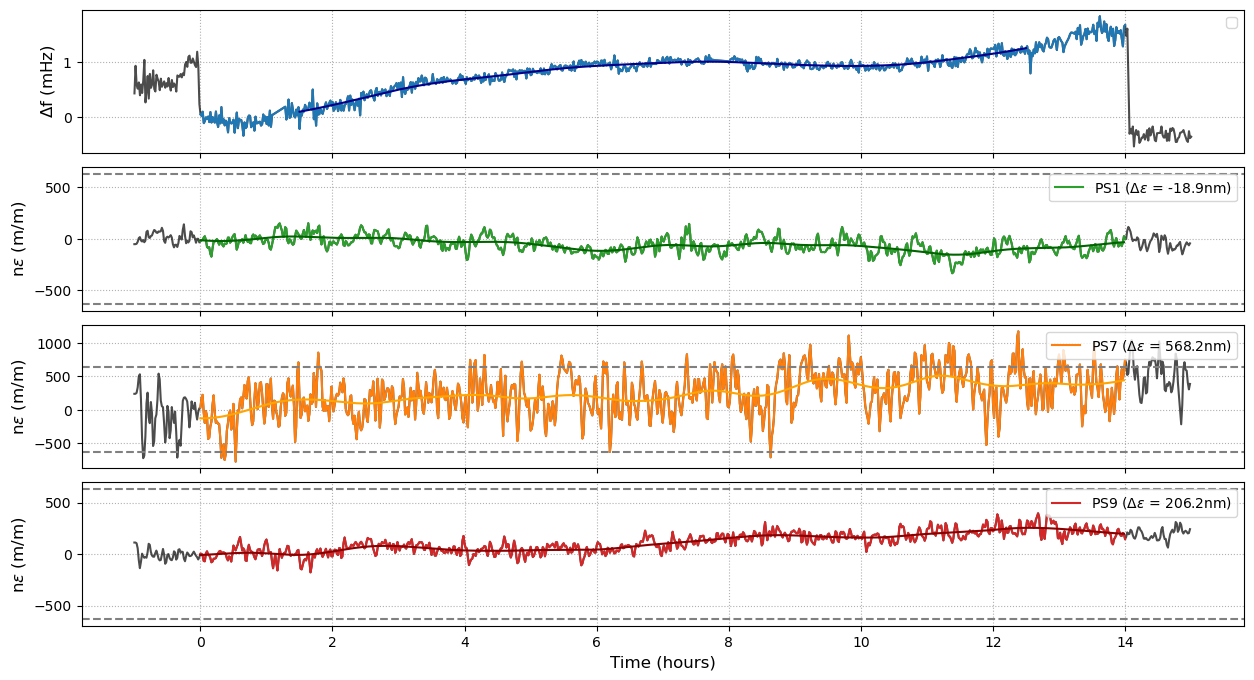

In [45]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    tscale, tunit = 1/3600, "hours"
    Tscale, Tunit = 1, "m/m"
    fscale, funit = 1e3, "mHz"

    alpha = 15e-6 * 1e9

    ps11_diff = round(__get_diff(ps11_smooth*alpha), 1)
    ps17_diff = round(__get_diff(ps17_smooth*alpha), 1)
    ps19_diff = round(__get_diff(ps19_smooth*alpha), 1)

    ax[0].plot(trx0*tscale, rx0*fscale, color="black", alpha=0.7)
    ax[0].plot(trx1*tscale, rx1*fscale, color="tab:blue")
    ax[0].plot(trx1*tscale, rx1_smooth*fscale, color="darkblue")
    ax[0].ticklabel_format(useOffset=False)

    ax[1].plot(tps01*tscale, ps01*alpha, color="black", alpha=0.7)
    ax[1].plot(tps11*tscale, ps11*alpha, color="tab:green", label=f"PS1 ($\Delta\epsilon$ = {ps11_diff}nm)")
    ax[1].plot(tps01*tscale, ps11_smooth*alpha, color="darkgreen")

    ax[2].plot(tps07*tscale, ps07*alpha, color="black", alpha=0.7)
    ax[2].plot(tps17*tscale, ps17*alpha, color="tab:orange", label=f"PS7 ($\Delta\epsilon$ = {ps17_diff}nm)")
    ax[2].plot(tps07*tscale, ps17_smooth*alpha, color="orange")

    ax[3].plot(tps09*tscale, ps09*alpha, color="black", alpha=0.7)
    ax[3].plot(tps19*tscale, ps19*alpha, color="tab:red", label=f"PS9 ($\Delta\epsilon$ = {ps19_diff}nm)")
    ax[3].plot(tps09*tscale, ps19_smooth*alpha, color="darkred")

    ax[0].set_ylabel(f"$\Delta$f ({funit})", fontsize=font)
    ax[1].set_ylabel(f"n$\epsilon$ ({Tunit})", fontsize=font)
    ax[2].set_ylabel(f"n$\epsilon$ ({Tunit})", fontsize=font)
    ax[3].set_ylabel(f"n$\epsilon$ ({Tunit})", fontsize=font)
    ax[3].set_xlabel(f"Time ({tunit})", fontsize=font)

    for _k in range(1, 4):
        ax[_k].axhline(633, color="grey", ls="--")
        ax[_k].axhline(-633, color="grey", ls="--")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_R{config['ring']}_strain_trend_{config['tbeg']}_{config['tend']}_zoomin.png",
            format="png", dpi=150, bbox_inches='tight')


In [ ]:
from functions.sagnac_to_tilt import __sagnac_to_tilt

dff = np.array(bs.fj_bs_inter)

dff_tilt = __sagnac_to_tilt(dff, config['ring'])

rx = Trace()
rx.data = dff_tilt
rx.stats.delta = 60
rx.stats.starttime = bs.time1.iloc[0]
rx.stats.station = "ROMY"
rx.stats.channel = f"FJ{config['ring']}"
rx.stats.network = "BW"

rx = Stream(rx)

rx.plot();

In [ ]:
fmin, fmax = 1/(24*3600), 1/(1*3600)


rxx = rx.copy()

rxx = rxx.trim(config['tbeg'], config['tend'], nearest_sample=False)
rxx = rxx.detrend("linear")

rxx = rxx.taper(0.05)

# rxx = rxx.filter("lowpass", freq=fmax, corners=2, zerophase=True)

rxx = rxx.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)

# rxx = rxx.resample(10*fmax, no_filter=True)
rxx = rxx.trim(config['tbeg'], config['tend'], nearest_sample=True)

rxx

rxx.plot();